# Link prediction on condensed matter collaborations

In [111]:
from datetime import datetime
import itertools
import math
from typing import List, Any, Dict, Tuple

import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate
import seaborn as sns
from tqdm import tqdm

# Typing
Author = int
Papers = List[Tuple[List[Author], datetime]]
NodePair = Tuple[Author, Author]
Edge = List[Tuple[Author, Author, Dict[str, datetime]]]

In [121]:
def _get_papers(filepath: str) -> Papers:
  """Read collaboration data in filepath and return all papers."""
  
  papers = list()
  # Get number of rows to read for the vertices.
  with open(filepath) as file:
    no_rows = int(file.readline().split(' ')[1])
 
  with open(filepath) as file:
    for paper in file.readlines()[no_rows+2:]:
      # Each line has the following format: epoch no_authors [ u v (w ...) ]
      epoch = datetime.fromtimestamp(int(paper.split(' ')[0]))
          
      no_authors = int(paper.split(' ')[1])
      index1 = paper.find('[')+2
      index2 = paper.find(']')-1

      authors = [int(auth) for auth in paper[index1:index2].split(' ')]
      assert no_authors == len(authors)
      
      papers.append((authors, epoch))
  return papers
def _filter_edgelist(edges: List[Edge], start, stop) -> List[Edge]: 
  """Filter edgelist.  If start/ stop is float, start/stop from the fraction of total edges. If datetime, this is used.""" 
  no_edges = len(edges)
  if start is None: start=0
  if stop is None: stop=1
  if type(start) is float or start == 0:
    start_index = int(start*no_edges)
    start = edges[start_index][2]['date']
  if type(stop) is float or stop == 1:
    stop_index = math.floor(stop*no_edges)-1
    stop = edges[stop_index][2]['date']
  return [edge for edge in edges if edge[2]['date'] >= start and edge[2]['date'] <= stop]
def get_edgelist(*, filepath='src/cond-mat.hg2', start=None, stop=None) -> List[Edge]:
  """Return E_[t_1, t_2]."""
  papers = _get_papers(filepath)
  edges = [
    (u, v, dict(date=date)) if u<v else (v, u, dict(date=date))
    for authors, date in papers
    for u, v in itertools.combinations(authors, 2)
  ]
  return _filter_edgelist(edges, start, stop)
def giant_component(graph: nx.Graph) -> nx.Graph: return graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
def get_graph(edgelist: List[Edge]) -> nx.Graph:
  """Add edge to graph. Contains edge attribute weight."""
  g = nx.Graph()
  
  for u, v, _ in edgelist:
    weight = g[u][v]["weight"]+1 if g.has_edge(u,v) else 1
    g.add_edge(u, v, weight=weight)
  
  return g
def report(graph:nx.Graph, probes: Tuple[Author, Author]):
  n = len(probes)
  print(f"Number of probes: {n}")
  a = sum([graph.has_edge(u, v) for u, v in probes])
  print(f"- already edge: {a} ({a/n:.0%})")
  non_edges = set(nx.non_edges(graph))
  ne = sum([np in non_edges for np in probes])
  print(f"- both nodes in graph: {ne} ({ne/n:.0%})")
  ng = sum([not (graph.has_node(u) and graph.has_node(v)) for u, v in probes])
  print(f"- not in graph: {ng} ({ng/n:.0%})")
def get_distances(graph: nx.Graph, cutoff: int = None) -> (List[NodePair], List[int]):
  """
  Get all non-edges using BFS. When cutoff provided, consider only node pairs with at most this distance.
  Returns:
  - nodepairs: tuple containing all nodepairs
  - distances: tuple containing all distances
  """
  return zip(
    *[
      [(u, v), distance]
      for u, (nbs_u, _) in tqdm(nx.all_pairs_dijkstra(graph, cutoff, weight=None), total=len(graph), desc="get_distances")
      for v, distance in nbs_u.items() if distance > 1 and (cutoff is None or distance <= cutoff) 
    ]
  )

In [112]:
def get_papers(filepath: str = "cond-mat.hg2") -> Papers:
  """Read collaboration data in filepath and return all papers."""
  
  papers = list()
  # Get number of rows to read for the vertices.
  with open(filepath) as file:
    no_rows = int(file.readline().split(' ')[1])
 
  with open(filepath) as file:
    for paper in file.readlines()[no_rows+2:]:
      # Each line has the following format: epoch no_authors [ u v (w ...) ]
      epoch = datetime.fromtimestamp(int(paper.split(' ')[0]))
          
      no_authors = int(paper.split(' ')[1])
      index1 = paper.find('[')+2
      index2 = paper.find(']')-1

      authors = [int(auth) for auth in paper[index1:index2].split(' ')]
      assert no_authors == len(authors)
      
      papers.append((authors, epoch))
  return papers
def get_edgelist(*, start=0, stop=1) -> List[Edge]:
  """
  Return edgelist from data. If data is not provided this is automatically 
  created using get_data. **kwargs are provided to this function.
  """
  papers = get_papers()
  edges = [
    (u, v, dict(date=date)) if u<v else (v, u, dict(date=date))
    for authors, date in papers
    for u, v in itertools.combinations(authors, 2)
  ]
  return _filter_edgelist(edges, start, stop)
def get_graph(edgelist: List[Edge]) -> nx.Graph:
  """Add edge to graph. Contains edge attribute weight."""
  g = nx.Graph()
  
  for u, v, _ in edgelist:
    weight = g[u][v]["weight"]+1 if g.has_edge(u,v) else 1
    g.add_edge(u, v, weight=weight)
  
  return g
def _filter_edgelist(edges: List[Edge], start: float, stop: float) -> List[Edge]:
  no_edges = len(edges)
  start_index = int(start*no_edges)
  start_date = edges[start_index][2]['date']
  stop_index = math.floor(stop*no_edges)-1
  stop_date = edges[stop_index][2]['date']
  return [edge for edge in edges if edge[2]['date'] >= start_date and edge[2]['date'] <= stop_date]

In [123]:
edges = get_edgelist(filepath='cond-mat.hg2')

In [130]:
len([_ for u, v, date in edges if date['date'].year <= 2000])/len(edges)

1.0

## Data characteristics

In [114]:
dates = pd.Series({date: len(authors) for authors, date in papers if len(authors) > 1})

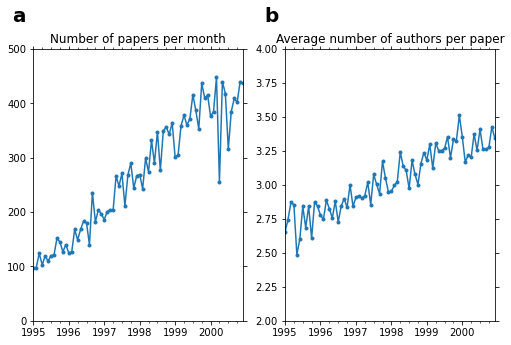

In [108]:
fig, axs = plt.subplots(ncols=2, figsize=(8.27, 5))

ax = dates.groupby(pd.Grouper(freq='M')).count().plot(ax=axs[0], marker='.')
axs[0].set_title('Number of papers per month')
axs[0].set_xlim(pd.to_datetime('1995-01-01'))
axs[0].set_ylim(0, 500)
axs[0].tick_params(which='both', top=True, right=True)
axs[0].text(-.1, 1.1, 'a', transform=axs[0].transAxes, size=20, weight='bold')

dates.groupby(pd.Grouper(freq='M')).mean().plot(ax=axs[1], marker='.')
axs[1].set_title('Average number of authors per paper')
axs[1].set_xlim(pd.to_datetime('1995-01-01'))
axs[1].set_ylim(2,4)
axs[1].tick_params(which='both', top=True, right=True)
axs[1].text(-.1, 1.1, 'b', transform=axs[1].transAxes, size=20, weight='bold')

fig.savefig('condmat.pdf')

In [110]:
dates.max()

23

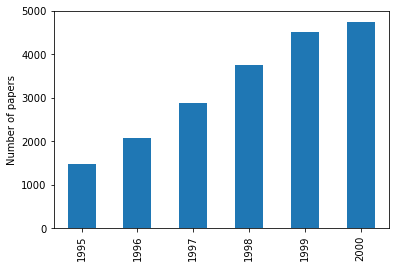

In [2]:
d = pd.Series([date.year for authors, date in papers if len(authors) > 1])
d.value_counts().sort_index().plot.bar()
plt.ylim(0, 5000)
plt.ylabel('Number of papers')
plt.savefig('temp/paperPerYear.svg')
plt.show()

In [8]:
d.value_counts(normalize=True).sort_index().cumsum()

1995    0.075480
1996    0.181944
1997    0.330182
1998    0.523379
1999    0.755832
2000    1.000000
dtype: float64

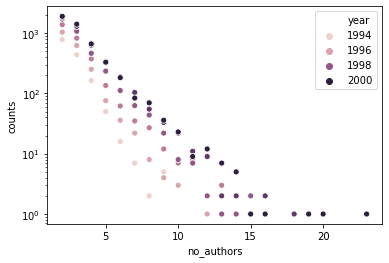

In [11]:
d = pd.DataFrame([dict(no_authors=len(authors), year=date.year) for authors, date in papers if len(authors) > 1])
d = d.groupby(['no_authors', 'year']).size().reset_index(name='counts')
sns.scatterplot('no_authors', 'counts', 'year', data=d, cmap='blues')
plt.yscale('log')
plt.savefig('temp/authorsPerPaper.svg')
plt.show()

## Graph characteristics

In the network `g` each node is an author. We connect two authors if they published a paper where they are co-authoring.

In [4]:
graph.describe(g)

Number of edges: 55275
	 in GC: 52588 (95%)
Number of nodes: 17216
	 in GC: 15081 (88%)
Density (in GC): 3.7e-04 (4.6e-04)


### Degree
The degree distrubtion of g. Up: without weights taking into account. Bottom: with taking weights into account. 

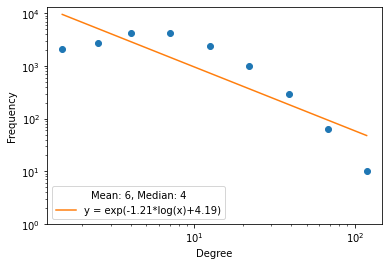

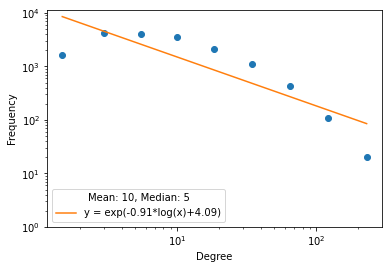

In [5]:
graph.degreeDistribution(g)
graph.degreeDistribution(g, 'weight')

### Density

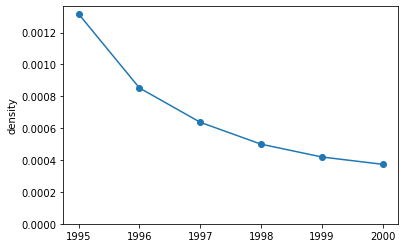

In [6]:
pd.Series({year: nx.density(from_edgelist(get_edgelist(stop=year))) for year in {attribute['date'].year for _, _, attribute in edges}}).plot(marker='o')
plt.ylabel('density')
plt.ylim(0);

### Weight
The distribution of weights (over the edges).

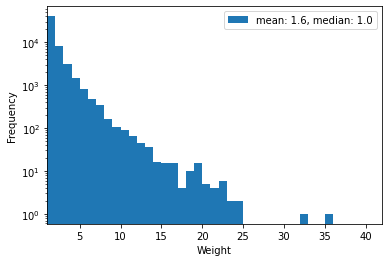

In [7]:
graph.weightDistribution(g, yscale='log')

### Distance

In [8]:
### Install teexgraph
# !wget -P /data/bruingjde https://github.com/franktakes/teexgraph/archive/master.zip
# !unzip /data/bruingjde/master.zip
# !rm /data/bruingjde/master.zip
# !mv /data/bruingjde/teexgraph-master/ /data/bruingjde/teexgraph
# !make /data/bruingjde/teexgraph listener

In [9]:
%%time
%%capture
!printf '%s\n' 'load_undirected temp/network.edges' 'dist_distri' > "temp/input.txt"
nx.write_edgelist(g, 'temp/network.edges', data=False)
! /data/bruingjde/teexgraph/teexgraph < temp/input.txt > temp/output.txt

def weighted_median(df: pd.Series) -> int:
    return (df.cumsum() < (df.sum() / 2)).idxmin()

CPU times: user 183 ms, sys: 36 ms, total: 219 ms
Wall time: 7.02 s


mean=6.3
median=6


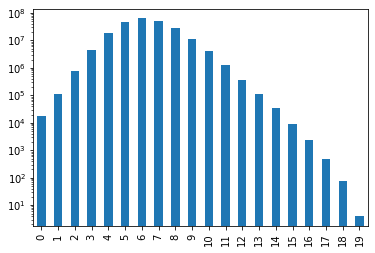

In [10]:
distances = pd.read_csv('temp/output.txt', '\t', names=['distance', 'counts'])['counts']
mean = np.average(distances.index, weights=distances)
distances.plot.bar()
plt.yscale('log')
print(f'{mean=:.1f}')
print(f'median={weighted_median(distances):.0f}')